## Multiclass classification for Fashin mnist with TF20 Eager Mode Code

![](https://tensorflow.org/images/fashion-mnist-sprite.png)

### References
- https://www.tensorflow.org/tutorials/keras/basic_classification
- https://github.com/zalandoresearch/fashion-mnist

In [1]:
train_labelsfrom __future__ import absolute_import, division, print_function, unicode_literals

# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-alpha0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images_npy, train_labels_npy), (test_images_npy, test_labels_npy) = fashion_mnist.load_data()

### Labels
Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
train_images_npy.shape


(60000, 28, 28)

In [5]:
train_labels_npy.shape

(60000,)

In [6]:
train_labels_npy[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [7]:
test_images_npy.shape


(10000, 28, 28)

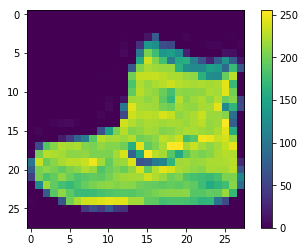

In [8]:
plt.figure()
plt.imshow(train_images_npy[0])
plt.colorbar()
plt.grid(False)
plt.show()

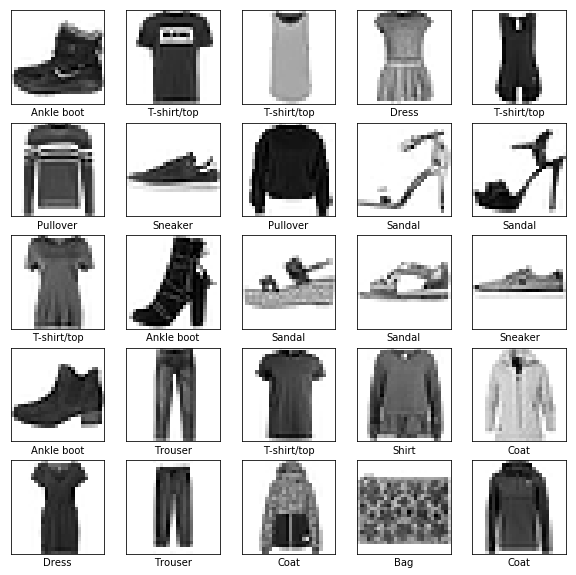

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_npy[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels_npy[i]])
plt.show()

In [10]:
type(train_images_npy), type(train_labels_npy), type(test_images_npy), type(test_labels_npy) 

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [11]:
def prepare_mnist_features_and_labels(x, y):
  x = tf.cast(x, tf.float64) / 255.0
  y = tf.cast(y, tf.int8)
  return x, y

def mnist_dataset(images_npy, labels_npy):
    ds = tf.data.Dataset.from_tensor_slices(
        (images_npy, labels_npy))
    ds = ds.map(prepare_mnist_features_and_labels)
    ds = ds.take(20000).shuffle(20000).batch(100)
    return ds


def mnist_test_dataset(images_npy, labels_npy):
    ds = tf.data.Dataset.from_tensor_slices((train_images_npy, train_labels_npy))
    ds = ds.map(prepare_mnist_features_and_labels)
    ds = ds.batch(100)
    return ds


In [12]:
model = tf.keras.Sequential((
    tf.keras.layers.Reshape(target_shape=(28 * 28,), input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation="softmax")))
model.build()
optimizer = tf.keras.optimizers.Adam()

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [14]:
@tf.function
def train_step(image, label):
  with tf.GradientTape() as tape:
    predictions = model(image)
    loss = loss_object(label, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(
      zip(gradients, model.trainable_variables))
  
  train_loss(loss)
  train_accuracy(label, predictions)

In [15]:
@tf.function
def test_step(image, label):
  predictions = model(image)
  t_loss = loss_object(label, predictions)
  
  test_loss(t_loss)
  test_accuracy(label, predictions)

In [16]:
EPOCHS = 5

for epoch in range(EPOCHS):
  for image, label in mnist_dataset(train_images_npy, train_labels_npy):
    train_step(image, label)
  
  for test_image, test_label in mnist_test_dataset(test_images_npy, test_labels_npy):
    test_step(test_image, test_label)
  
  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(), 
                         train_accuracy.result()*100,
                         test_loss.result(), 
                         test_accuracy.result()*100))

Epoch 1, Loss: 0.8649387359619141, Accuracy: 67.76000213623047, Test Loss: 0.5995535254478455, Test Accuracy: 78.07833862304688
Epoch 2, Loss: 0.7013459801673889, Accuracy: 74.17250061035156, Test Loss: 0.553555965423584, Test Accuracy: 80.01083374023438
Epoch 3, Loss: 0.6286730170249939, Accuracy: 76.91000366210938, Test Loss: 0.5293983817100525, Test Accuracy: 80.86555480957031
Epoch 4, Loss: 0.5849095582962036, Accuracy: 78.55125427246094, Test Loss: 0.5218731164932251, Test Accuracy: 81.12333679199219
Epoch 5, Loss: 0.5527161359786987, Accuracy: 79.74099731445312, Test Loss: 0.505156934261322, Test Accuracy: 81.80933380126953


In [17]:
predictions = model.predict(test_images_npy)


In [18]:
predictions[0]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [19]:
np.argmax(predictions[0])


9

In [20]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

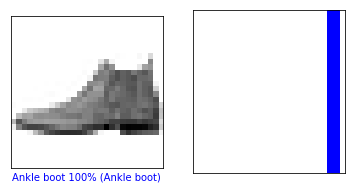

In [21]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels_npy, test_images_npy)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels_npy)
plt.show()

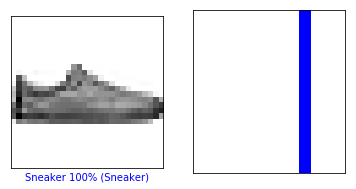

In [22]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels_npy, test_images_npy)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels_npy)
plt.show()

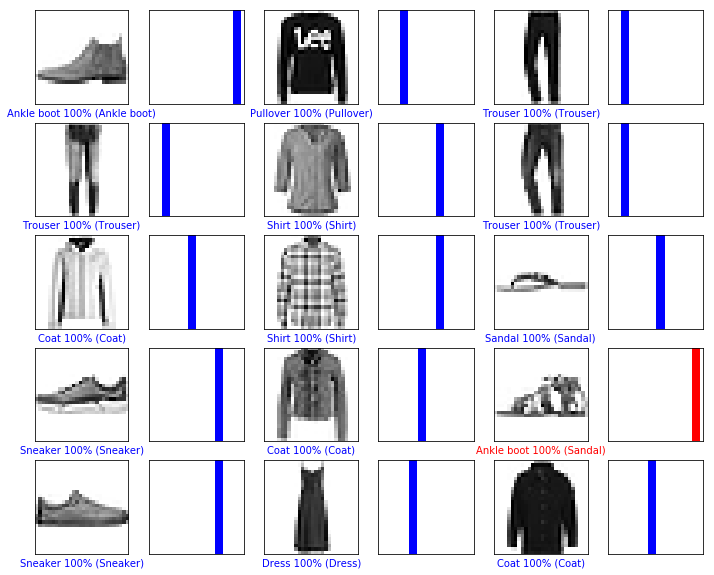

In [23]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
# 올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타냅니다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels_npy, test_images_npy)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels_npy)
plt.show()

In [24]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[ 0.05413764, -0.00278482,  0.10252772, ..., -0.06352715,
          0.01331665,  0.05901068],
        [-0.02238854,  0.02708791,  0.10770576, ..., -0.1912847 ,
          0.1146743 ,  0.10199874],
        [-0.03460497,  0.06776547,  0.04553392, ..., -0.05805642,
          0.05450844, -0.03763776],
        ...,
        [-0.08195796, -0.08883276, -0.10935521, ..., -0.04466285,
          0.04919361,  0.0067226 ],
        [ 0.13134037, -0.0218846 , -0.06380349, ...,  0.07490554,
          0.06109076, -0.08591981],
        [-0.01309861, -0.00102221,  0.02549917, ...,  0.05694835,
         -0.05663577,  0.01650275]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=
 array([ 0.00613929,  0.08798447,  0.03824895,  0.0023027 ,  0.00412649,
         0.06720273,  0.00703124,  0.05544642, -0.01502409, -0.00209195],
       dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(10, 20) dtype=